# Download data and import libraries

In [1]:
%matplotlib inline 

import pandas as pd
import numpy as np

from pandas_profiling import ProfileReport
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score

from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [2]:
# load data    
with open('./transfer_files/df_data.pickle', 'rb') as f:
    df_data = pickle.load(f)
df_data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated_Duration,ExitRates,PageValues,Month,Revenue,SpecialDay_0.2,...,TrafficType_3,TrafficType_4,TrafficType_5,TrafficType_6,TrafficType_7,TrafficType_8,TrafficType_9,VisitorType_Other,VisitorType_Returning_Visitor,Weekend_True
0,0,0.0,0,0.0,0.000000,0.20,0.0,2,False,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0.0,0,0.0,64.000000,0.10,0.0,2,False,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0.0,0,0.0,0.000000,0.20,0.0,2,False,0,...,1,0,0,0,0,0,0,0,1,0
3,0,0.0,0,0.0,2.666667,0.14,0.0,2,False,0,...,0,1,0,0,0,0,0,0,1,0
4,0,0.0,0,0.0,627.500000,0.05,0.0,2,False,0,...,0,1,0,0,0,0,0,0,1,1


# Generate user-bahavior clusters based on the purchasing behavior data for the complete dataset. 

1. How many clusters are there? What are the significant differences between the various clusters in terms of the size of the clusters and purchase ratio. 
3. Perform a detailed analysis for each cluster corresponding to the variations in features and identify some behaviors corresponding to each particular cluster. 

In [3]:
#selecting data before transformations for supervised learning
df_clustering = df_data.copy()
df_clustering.columns

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated_Duration', 'ExitRates',
       'PageValues', 'Month', 'Revenue', 'SpecialDay_0.2', 'SpecialDay_0.4',
       'SpecialDay_0.6', 'SpecialDay_0.8', 'SpecialDay_1.0',
       'OperatingSystems_2', 'OperatingSystems_3', 'OperatingSystems_4',
       'OperatingSystems_5', 'OperatingSystems_6', 'OperatingSystems_7',
       'OperatingSystems_8', 'Browser_10', 'Browser_11', 'Browser_12',
       'Browser_13', 'Browser_2', 'Browser_3', 'Browser_4', 'Browser_5',
       'Browser_6', 'Browser_7', 'Browser_8', 'Browser_9', 'Region_2',
       'Region_3', 'Region_4', 'Region_5', 'Region_6', 'Region_7', 'Region_8',
       'Region_9', 'TrafficType_10', 'TrafficType_11', 'TrafficType_12',
       'TrafficType_13', 'TrafficType_14', 'TrafficType_15', 'TrafficType_16',
       'TrafficType_17', 'TrafficType_18', 'TrafficType_19', 'TrafficType_2',
       'TrafficType_20', 'TrafficType_3', 'Traffic

In [4]:
df_clustering['Revenue'].value_counts()

False    10137
True      1705
Name: Revenue, dtype: int64

In [5]:
#from helper functions

def return_feature_rank_from_RF(X_train,y_train, features): 
# Build a forest and compute the impurity-based feature importances
    forest = ExtraTreesClassifier(n_estimators=20,random_state=0)
    forest.fit(X_train, y_train)
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(X_train.shape[1]):
        print("%d. %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))

    # Plot the impurity-based feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X_train.shape[1]), importances[indices],
            color="r", yerr=std[indices], align="center")
    plt.xticks(range(X_train.shape[1]), indices)
    plt.xlim([-1, X_train.shape[1]])
    plt.show()

    return (indices,importances)

Feature ranking:
1. PageValues (0.318518)
2. ProductRelated_Duration (0.092071)
3. ExitRates (0.088754)
4. Administrative_Duration (0.061387)
5. Administrative (0.061031)
6. Month (0.055146)
7. Informational_Duration (0.032119)
8. Informational (0.031637)
9. Weekend_True (0.020194)
10. Region_3 (0.018343)
11. Browser_2 (0.016280)
12. TrafficType_2 (0.015153)
13. VisitorType_Returning_Visitor (0.013480)
14. OperatingSystems_2 (0.013266)
15. Region_4 (0.012047)
16. Region_2 (0.011865)
17. Region_6 (0.010093)
18. OperatingSystems_3 (0.009425)
19. Region_7 (0.009333)
20. Browser_4 (0.007884)
21. TrafficType_4 (0.007584)
22. TrafficType_3 (0.007192)
23. Region_9 (0.006816)
24. Region_8 (0.006439)
25. OperatingSystems_4 (0.006007)
26. Browser_5 (0.005830)
27. TrafficType_8 (0.005562)
28. TrafficType_10 (0.005432)
29. TrafficType_6 (0.005235)
30. Region_5 (0.004904)
31. TrafficType_5 (0.004080)
32. TrafficType_11 (0.004072)
33. TrafficType_13 (0.003702)
34. Browser_10 (0.003334)
35. TrafficTy

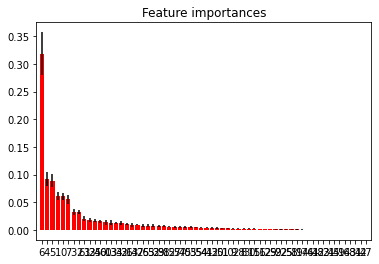

In [6]:
#Calculate, print, and plot the feature importances, in descending order of importance.
y = df_clustering['Revenue'].values
del df_clustering['Revenue']

features = list(df_clustering.columns)
X = df_clustering.values

indices, importances = return_feature_rank_from_RF(X,y, features)

##### It is reasonable to look at only features with importance > 0.030

In [7]:
idx = list(np.where(importances > 0.030)[0])
selected_columns = [f for f in features if features.index(f) in idx]

print("Selected features:")
selected_columns

Selected features:


['Administrative',
 'Administrative_Duration',
 'Informational',
 'Informational_Duration',
 'ProductRelated_Duration',
 'ExitRates',
 'PageValues',
 'Month']

In [8]:
X_train = df_data[selected_columns].values
y_train = y

## Clustering
##### Further reducing dimentions

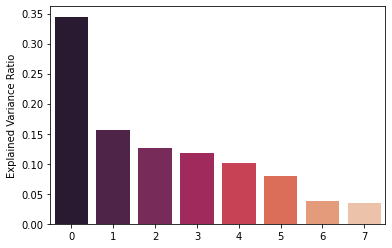

In [9]:
scaler = StandardScaler().fit(X_train)
X_scaled = scaler.transform(X_train)


pca = PCA()
pca.fit(X_scaled)
expl_var = pca.explained_variance_ratio_
x = list(range(expl_var.shape[0]))

sns.barplot(x=x, y=expl_var, palette="rocket")
plt.ylabel("Explained Variance Ratio")
plt.show()

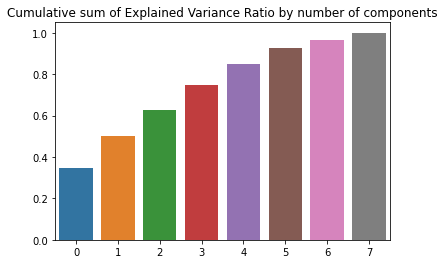

In [10]:
y = expl_var.cumsum()
sns.barplot(x=x, y=y)
plt.title("Cumulative sum of Explained Variance Ratio by number of components")
plt.show()

In [11]:
selected_n_components = 5 #since total explained variance ratio is >85%
pca = PCA(n_components=selected_n_components)
X_red = pca.fit_transform(X_scaled)

print(X_red.shape)

(11842, 5)


##### Clustering reduced feature data

Using $k$-means clustering with $k \in [1, 20]$ to the reduced features data. 
Visualize the associated distortion scores and computational times.


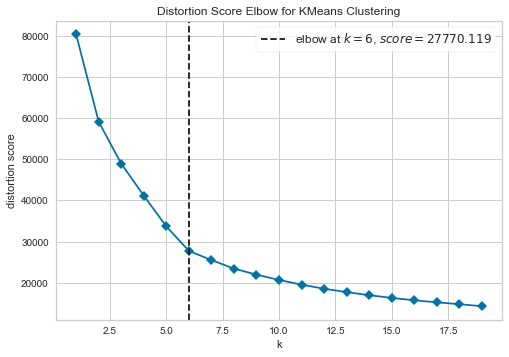

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [12]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(
    model, k=(1,20), timings=False
)

visualizer.fit(X_red)    # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

**The “elbow” method shows that the optimal number of clusters  is 6.**

In [13]:
n = 6
# Instantiate the clustering model
clusters = KMeans(n_clusters = n, random_state=2)
# Assign the points in the reduced dataset to clusters
C_vals = np.array(clusters.fit_predict(X_red))

In [14]:
df_clusters = df_data[selected_columns + ['VisitorType_Returning_Visitor', 'Revenue']].copy()
df_clusters['ClusterID'] = C_vals
df_clusters.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated_Duration,ExitRates,PageValues,Month,VisitorType_Returning_Visitor,Revenue,ClusterID
0,0,0.0,0,0.0,0.000000,0.20,0.0,2,1,False,5
1,0,0.0,0,0.0,64.000000,0.10,0.0,2,1,False,0
2,0,0.0,0,0.0,0.000000,0.20,0.0,2,1,False,5
3,0,0.0,0,0.0,2.666667,0.14,0.0,2,1,False,5
4,0,0.0,0,0.0,627.500000,0.05,0.0,2,1,False,0


## Cluster analysis:

In [15]:
df_tmp = df_clusters.copy()
df_tmp["Cluster size"] = df_tmp.index
df_tmp['Purchase ratio'] = df_tmp['Revenue']
df_tmp1 = df_tmp.groupby('ClusterID').agg({"Cluster size": "count",
                                               "Purchase ratio": "sum",
                                           'VisitorType_Returning_Visitor': "mean"
                                              })

print("Total number of records:", len(df_tmp))
df_tmp1["Purchase ratio"] = df_tmp1["Purchase ratio"]/len(df_tmp)
df_tmp1 = df_tmp1.reset_index()
df_tmp1

Total number of records: 11842


,ClusterID,Cluster size,Purchase ratio,VisitorType_Returning_Visitor
0,0,4036,0.019422,0.900149
1,1,1503,0.024405,0.851630
2,2,659,0.014862,0.902883
3,3,695,0.043996,0.716547
4,4,3641,0.040534,0.792914
5,5,1308,0.000760,0.948777


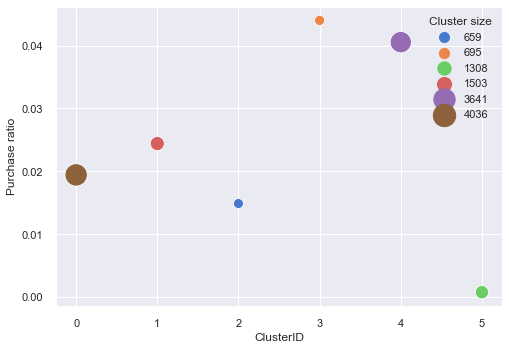

In [16]:
sns.set_theme(style="darkgrid")
sns.scatterplot(
    data=df_tmp1, x="ClusterID", y="Purchase ratio", 
    hue="Cluster size", size="Cluster size",
    sizes=(100, 500), hue_norm=(0, 7), 
    palette="muted", legend="full"
)
plt.show()

In [17]:
df_clusters[['ClusterID',
             'Administrative_Duration', 'Informational_Duration', 'ProductRelated_Duration',
             'Revenue']].groupby('ClusterID').describe().T

ClusterID                                0            1            2  \
Administrative_Duration count  4036.000000  1503.000000   659.000000   
                        mean     25.707882   267.360290   170.116007   
                        std      45.431048   162.643223   156.804332   
                        min       0.000000    27.000000     0.000000   
                        25%       0.000000   152.723214    54.075000   
                        50%       0.000000   225.450000   133.466667   
                        75%      37.000000   334.875000   241.993056   
                        max     306.000000   827.200000   828.052632   
Informational_Duration  count  4036.000000  1503.000000   659.000000   
                        mean      5.332097    18.260314   267.699538   
                        std      22.591142    36.378879   149.421861   
                        min       0.000000     0.000000     9.500000   
                        25%       0.000000     0.000000   151.125000   
                        50%       0.000000     0.000000   239.200000   
                        75%       0.000000    19.200000   360.083333   
                        max     255.000000   246.800000   689.833333   
ProductRelated_Duration count  4036.000000  1503.000000   659.000000   
                        mean    735.675253  1857.088053  2452.146238   
                        std     830.137232  1657.247035  1961.364832   
                        min       0.000000     0.000000    17.000000   
                        25%     183.666667   632.825000   913.352976   
                        50%     453.687500  1384.972222  1887.232143   
                        75%     983.125000  2529.673955  3676.599441   
                        max    6951.972222  8147.111565  8205.687940   

ClusterID                                3            4            5  
Administrative_Duration count   695.000000  3641.000000  1308.000000  
                        mean     72.788721    30.664580     1.302026  
                        std      98.763333    45.860665    12.718712  
                        min       0.000000     0.000000     0.000000  
                        25%       0.000000     0.000000     0.000000  
                        50%      44.016667     0.000000     0.000000  
                        75%     101.000000    52.500000     0.000000  
                        max     739.209195   284.000000   256.500000  
Informational_Duration  count   695.000000  3641.000000  1308.000000  
                        mean     11.464408     4.929606     0.083486  
                        std      34.636309    19.486539     1.402131  
                        min       0.000000     0.000000     0.000000  
                        25%       0.000000     0.000000     0.000000  
                        50%       0.000000     0.000000     0.000000  
                        75%       0.000000     0.000000     0.000000  
                        max     339.500000   249.500000    34.200000  
ProductRelated_Duration count   695.000000  3641.000000  1308.000000  
                        mean   1147.834817  1083.336683    52.645722  
                        std    1023.424072  1226.956915   141.690218  
                        min       4.000000     0.000000     0.000000  
                        25%     492.950000   251.291667     0.000000  
                        50%     856.416667   654.875000     0.000000  
                        75%    1437.300000  1423.790476    47.000000  
                        max    7793.158685  8068.742154  1787.500000

**Cluster 0:**<br>
This cluster has highest size, has 90% of returning visitors. Visitors are most likely to shop in May. 

**Cluster 1:**<br>
Most likely represent general visitors. Visitors in this cluster are more likely to shop in the second half of the year. This cluster is leading in time spent on the Administrative pages.

**Cluster 2:**<br>
Alhough similar to Claster 1, visitors in this cluster are mosre likely to shop in the last quater of a year they spend more time on the Information and ProductRelated pages.

In [18]:
df_clusters[['ClusterID','ExitRates',
       'PageValues', 'Month', 'VisitorType_Returning_Visitor',
             'Revenue']].groupby('ClusterID').describe().T

ClusterID                                      0            1           2  \
ExitRates                     count  4036.000000  1503.000000  659.000000   
                              mean      0.034911     0.020230    0.021441   
                              std       0.024573     0.013912    0.013977   
                              min       0.000000     0.000000    0.000000   
                              25%       0.015461     0.010765    0.011814   
                              50%       0.028609     0.017544    0.018254   
                              75%       0.050000     0.026461    0.027737   
                              max       0.128571     0.116667    0.104082   
PageValues                    count  4036.000000  1503.000000  659.000000   
                              mean      1.162974     4.831114    7.367688   
                              std       4.174288     8.407250   12.328820   
                              min       0.000000     0.000000    0.000000   
                              25%       0.000000     0.000000    0.000000   
                              50%       0.000000     0.000000    0.000000   
                              75%       0.000000     6.743448   10.130780   
                              max      29.243250    52.051650   79.484039   
Month                         count  4036.000000  1503.000000  659.000000   
                              mean      4.407334     8.185629    8.288316   
                              std       1.291507     3.112751    3.260060   
                              min       2.000000     2.000000    2.000000   
                              25%       3.000000     5.000000    5.000000   
                              50%       5.000000     9.000000   10.000000   
                              75%       5.000000    11.000000   11.000000   
                              max       8.000000    12.000000   12.000000   
VisitorType_Returning_Visitor count  4036.000000  1503.000000  659.000000   
                              mean      0.900149     0.851630    0.902883   
                              std       0.299839     0.355585    0.296342   
                              min       0.000000     0.000000    0.000000   
                              25%       1.000000     1.000000    1.000000   
                              50%       1.000000     1.000000    1.000000   
                              75%       1.000000     1.000000    1.000000   
                              max       1.000000     1.000000    1.000000   

ClusterID                                     3            4            5  
ExitRates                     count  695.000000  3641.000000  1308.000000  
                              mean     0.016685     0.029900     0.165046  
                              std      0.012969     0.020674     0.041713  
                              min      0.000000     0.000000     0.084615  
                              25%      0.007407     0.014815     0.122222  
                              50%      0.013377     0.025000     0.200000  
                              75%      0.022882     0.040000     0.200000  
                              max      0.075000     0.137427     0.200000  
PageValues                    count  695.000000  3641.000000  1308.000000  
                              mean    47.052870     1.368371     0.000000  
                              std     15.403333     4.471007     0.000000  
                              min     21.471420     0.000000     0.000000  
                              25%     33.612658     0.000000     0.000000  
                              50%     44.711034     0.000000     0.000000  
                              75%     57.777049     0.000000     0.000000  
                              max     85.752859    27.777259     0.000000  
Month                         count  695.000000  3641.000000  1308.000000  
                              mean     8.079137    10.884372     7.084098  
              

**Cluster 5:**

This cluster most likelly represents visitors that did not plan to buy products. It has the highest ExitRate and the lowest revenue record and visitors in this cluster spent the least amount of time on Administrative, Informational or ProductRelated wed pages. Interestingly 94.87% of those visitors are ReturningVisitors

**Cluster 4:**
The most interesting cluster is Cluster 4. It has second highest purchase ratio and size at the same time.**

Buyers in this cluster mostly were shopping during November and December and spent considerably less time om Administrative or Informational pages of the websites. These buyers are less likely to return than buyers from in other clusters (exept cluster 3)

In [19]:
df_cl4 = df_clusters[df_clusters['ClusterID'] == 4]
df_cl4.describe().T

,count,mean,std,min,25%,50%,75%,max
Administrative,3641.0,1.277396,1.668044,0.0,0.000000,0.000,2.000000,7.000000
Administrative_Duration,3641.0,30.664580,45.860665,0.0,0.000000,0.000,52.500000,284.000000
Informational,3641.0,0.207086,0.597581,0.0,0.000000,0.000,0.000000,4.000000
Informational_Duration,3641.0,4.929606,19.486539,0.0,0.000000,0.000,0.000000,249.500000
ProductRelated_Duration,3641.0,1083.336683,1226.956915,0.0,251.291667,654.875,1423.790476,8068.742154
ExitRates,3641.0,0.029900,0.020674,0.0,0.014815,0.025,0.040000,0.137427
PageValues,3641.0,1.368371,4.471007,0.0,0.000000,0.000,0.000000,27.777259
Month,3641.0,10.884372,1.140455,5.0,11.000000,11.000,12.000000,12.000000
VisitorType_Returning_Visitor,3641.0,0.792914,0.405273,0.0,1.000000,1.000,1.000000,1.000000
ClusterID,3641.0,4.000000,0.000000,4.0,4.000000,4.000,4.000000,4.000000


In [20]:
df_other = df_clusters[df_clusters['ClusterID'] != 4]
df_other.describe().T

,count,mean,std,min,25%,50%,75%,max
Administrative,8201.0,2.546153,3.486363,0.0,0.000000,1.000000,4.000000,24.000000
Administrative_Duration,8201.0,81.697011,134.953775,0.0,0.000000,8.000000,115.800000,828.052632
Informational,8201.0,0.531155,1.251257,0.0,0.000000,0.000000,0.000000,14.000000
Informational_Duration,8201.0,28.466840,86.151284,0.0,0.000000,0.000000,0.000000,689.833333
ProductRelated_Duration,8201.0,1005.116307,1313.850824,0.0,138.000000,523.541667,1345.755952,8205.687940
ExitRates,8201.0,0.050349,0.056437,0.0,0.014286,0.027249,0.059420,0.200000
PageValues,8201.0,6.037310,14.638953,0.0,0.000000,0.000000,0.000000,85.752859
Month,8201.0,6.149738,3.027317,2.0,5.000000,5.000000,8.000000,12.000000
VisitorType_Returning_Visitor,8201.0,0.883673,0.320637,0.0,1.000000,1.000000,1.000000,1.000000
ClusterID,8201.0,1.395683,1.818570,0.0,0.000000,1.000000,2.000000,5.000000


***
**Cluster 3:**

Although Cluster 3 has the highest purchase ratio it is just second in size.

Visitors from the cluster with most purchases are more likely to be Returning Visitors who spent very little time on Administartive and Informational pages of the websights compared to the other visitors.

<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


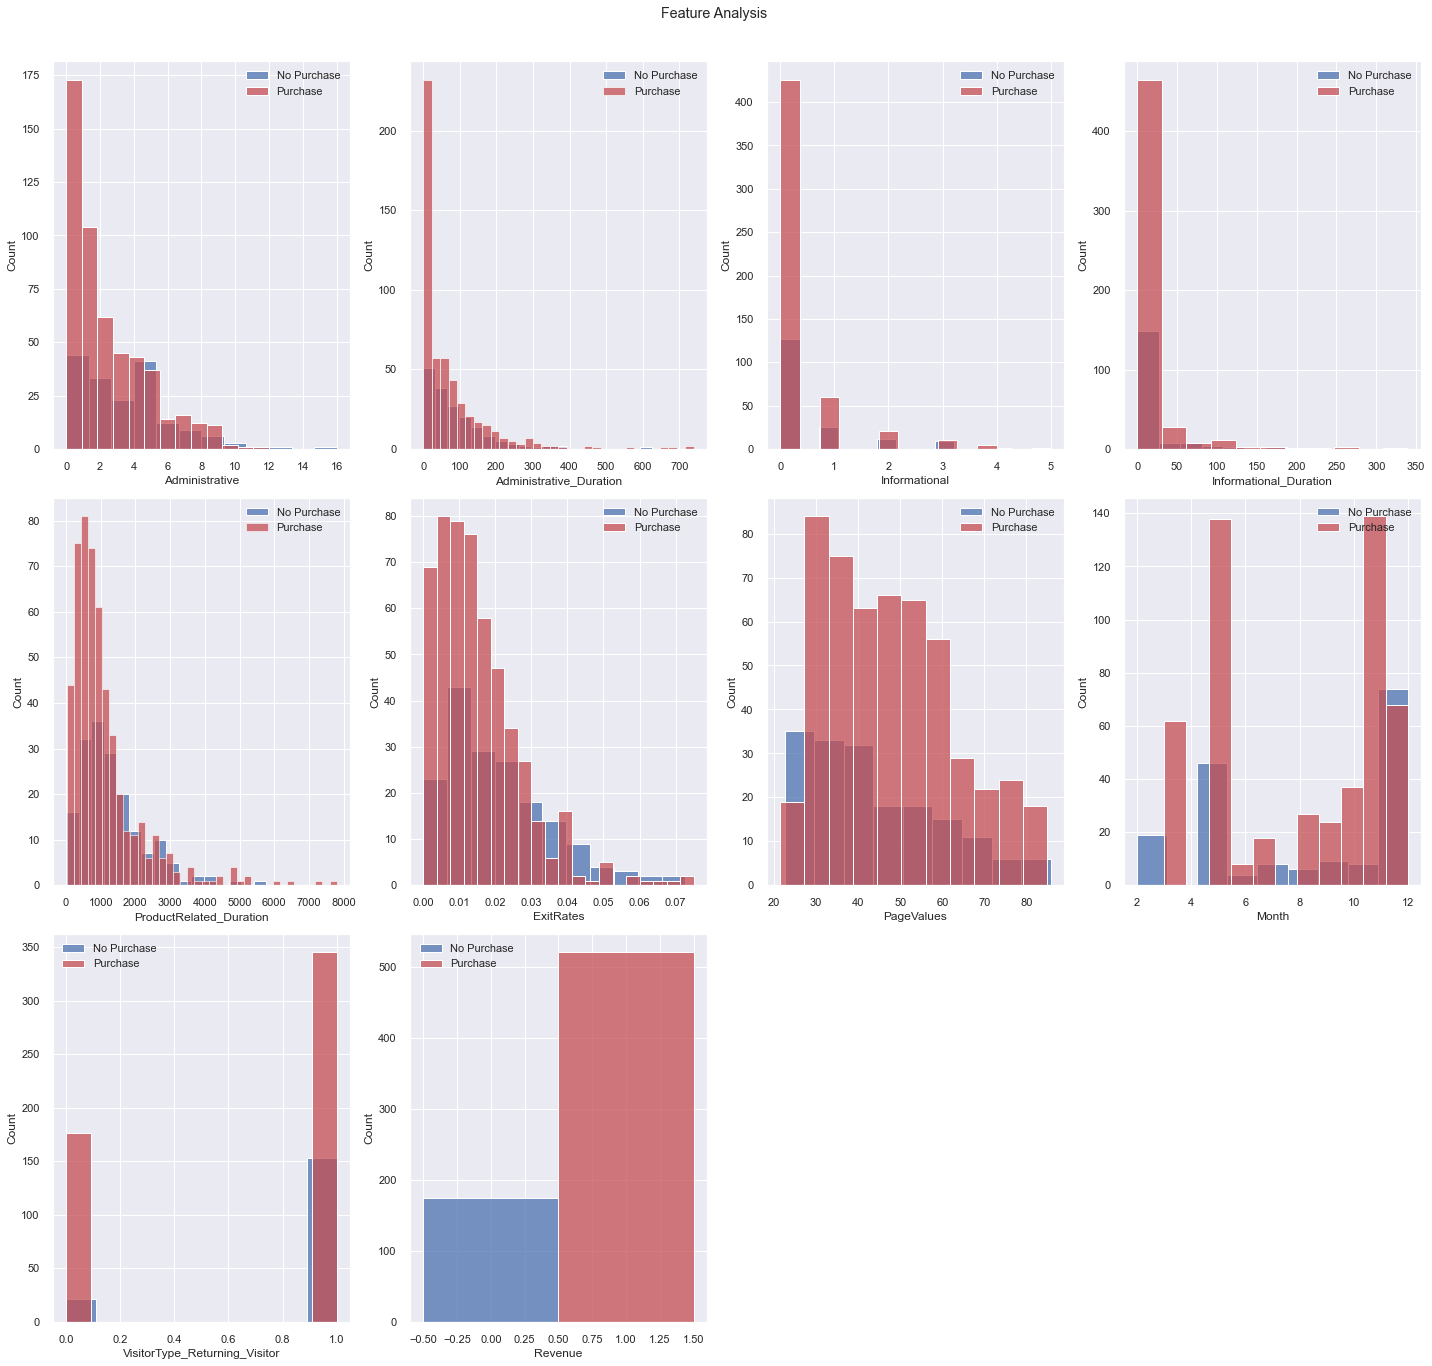

In [21]:
# Next, to analyze composition of each cluster
#Cluster 3
result = df_clusters.loc[df_clusters['ClusterID'] == 3]


fig = plt.figure(figsize = (20, 25))
j = 0
for i,item in enumerate(result.columns):
    if item != "ClusterID":
        plt.subplot(4, 4, j+1)
        j += 1
        sns.histplot(result[item][result['Revenue']==False], color='b', label = 'No Purchase')
        sns.histplot(result[item][result['Revenue']==True], color='r', label = 'Purchase')
        plt.legend(loc='best')

fig.suptitle('Feature Analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

In [22]:
df_cl3 = df_clusters[df_clusters['ClusterID'] == 3]
df_cl3.describe().T

,count,mean,std,min,25%,50%,75%,max
Administrative,695.0,2.517986,2.598360,0.00000,0.000000,2.000000,4.000000,16.000000
Administrative_Duration,695.0,72.788721,98.763333,0.00000,0.000000,44.016667,101.000000,739.209195
Informational,695.0,0.332374,0.770700,0.00000,0.000000,0.000000,0.000000,5.000000
Informational_Duration,695.0,11.464408,34.636309,0.00000,0.000000,0.000000,0.000000,339.500000
ProductRelated_Duration,695.0,1147.834817,1023.424072,4.00000,492.950000,856.416667,1437.300000,7793.158685
ExitRates,695.0,0.016685,0.012969,0.00000,0.007407,0.013377,0.022882,0.075000
PageValues,695.0,47.052870,15.403333,21.47142,33.612658,44.711034,57.777049,85.752859
Month,695.0,8.079137,3.217085,2.00000,5.000000,9.000000,11.000000,12.000000
VisitorType_Returning_Visitor,695.0,0.716547,0.450999,0.00000,0.000000,1.000000,1.000000,1.000000
ClusterID,695.0,3.000000,0.000000,3.00000,3.000000,3.000000,3.000000,3.000000
